# Population Estimates: Compute CBG-level estimates using existing Cloud Factory annotations

We submitted ~700 tiles for CF to review prior to performing the population estimates. These tiles covered the same geographic areas for 2016, 2018 and 2020, and were sampled via random sampling stratified at the CBG-level. For this reason, although a CBG may not have been fully reviewed by CF, we assume that the 1 or 2 tiles reviewed for the CBG are representative of the small building density (number of small buildings per parcel) for the CBG. 

In [2]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [3]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [30]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
SJ_RES_PARCELS_FP = os.path.join(PERMIT_INPUT_FP, 'san_jose_parcels_res.geojson')

# Load sources for each year
TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * CF annotations
CF_LABELS = pd.read_csv(os.path.join(OAK_FP, 'CloudFactory/cf_coords.csv'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

100%|██████████| 3324/3324 [00:00<00:00, 14191.21it/s]


## 1. Identify the universe of parcels annotated by CF

In [31]:
# Convert to GDF
CF_LABELS = gpd.GeoDataFrame(
    CF_LABELS, geometry=gpd.points_from_xy(CF_LABELS.longitude, CF_LABELS.latitude), crs='EPSG:4326')

In [32]:
# Collect tile names
CF_tiles = []
for cf_round in [1, 2]:
    round_path = os.path.join(
        OAK_FP, 'outputs/Temporal-Error-Analysis/Round{}/CF_Visualizations/2018'.format(cf_round))
    round_tiles = glob.glob(os.path.join(round_path, '*.png'))
    round_tiles = [tile.split(os.path.sep)[-1].replace('-small_2018.png', '') for tile in round_tiles]
    CF_tiles.extend(round_tiles)

In [33]:
# Collect tile geometries
CF_area_coverage = tiles_gdf['2020'].copy()
CF_area_coverage = CF_area_coverage.loc[CF_area_coverage['file'].isin(CF_tiles)]

In [56]:
# Collect associated parcels
CF_parcels = sj_parcels_cbgs.sjoin(CF_area_coverage, how='left', predicate='intersects')
CF_parcels = CF_parcels.loc[~CF_parcels['index_right'].isna()]
CF_parcels.drop('index_right', axis=1, inplace=True)

# Drop duplicate parcels (these are caused by parcels that belong to more than 1 tile)
CF_parcels.drop_duplicates('APN', inplace=True)
CF_parcels.drop('file', axis=1, inplace=True)

In [57]:
# CF annotated 17,973 unique parcels in total, for three years
len(CF_parcels)

17973

In [171]:
# Compute small building density per parcel per year for each CBG
cbg_density = pd.DataFrame()
parcel_density = pd.DataFrame()
for year in ['2016', '2018', '2020']:
    parcel_density_year = CF_parcels.copy()
    cf_labels_year = CF_LABELS.loc[CF_LABELS['year'] == int(year)]
    
    # Assign CF points to parcels
    parcel_density_year = parcel_density_year.sjoin(cf_labels_year, how='left')
    
    # Parcel density
    parcel_density_year = parcel_density_year.groupby(
        ['APN', 'GEOID'])['index_right'].count().reset_index()
    parcel_density_year['year'] = year
    
    # Aggregate at the CBG level
    cbg_density_year = parcel_density_year.groupby('GEOID').agg(
        {'index_right': ['mean', 'std']}).reset_index()
    cbg_density_year.columns = ['-'.join(l) if l[1] != '' else l[0] for l in cbg_density_year.columns]
    
    cbg_density_year.rename(columns={'index_right-mean': 'mean_density', 
                                     'index_right-std': 'std_density'}, inplace=True)
    cbg_density_year['year'] = year
    
    # Append
    cbg_density = pd.concat([cbg_density, cbg_density_year])
    
    parcel_density_year.rename(columns={'index_right': 'parcel_density'}, inplace=True)
    parcel_density = pd.concat([parcel_density, parcel_density_year])

## 2. Aggregate at the CBG and neighborhood level

In [172]:
# Add neighborhood type
cbg_density = pd.merge(
    cbg_density, cbg_income_2016_SJ[['GEOID', 'neighborho', 'geometry']], how='left', 
    validate='many_to_one')

parcel_density = pd.merge(
    parcel_density, cbg_income_2016_SJ[['GEOID', 'neighborho']], how='left', validate='many_to_one'
)

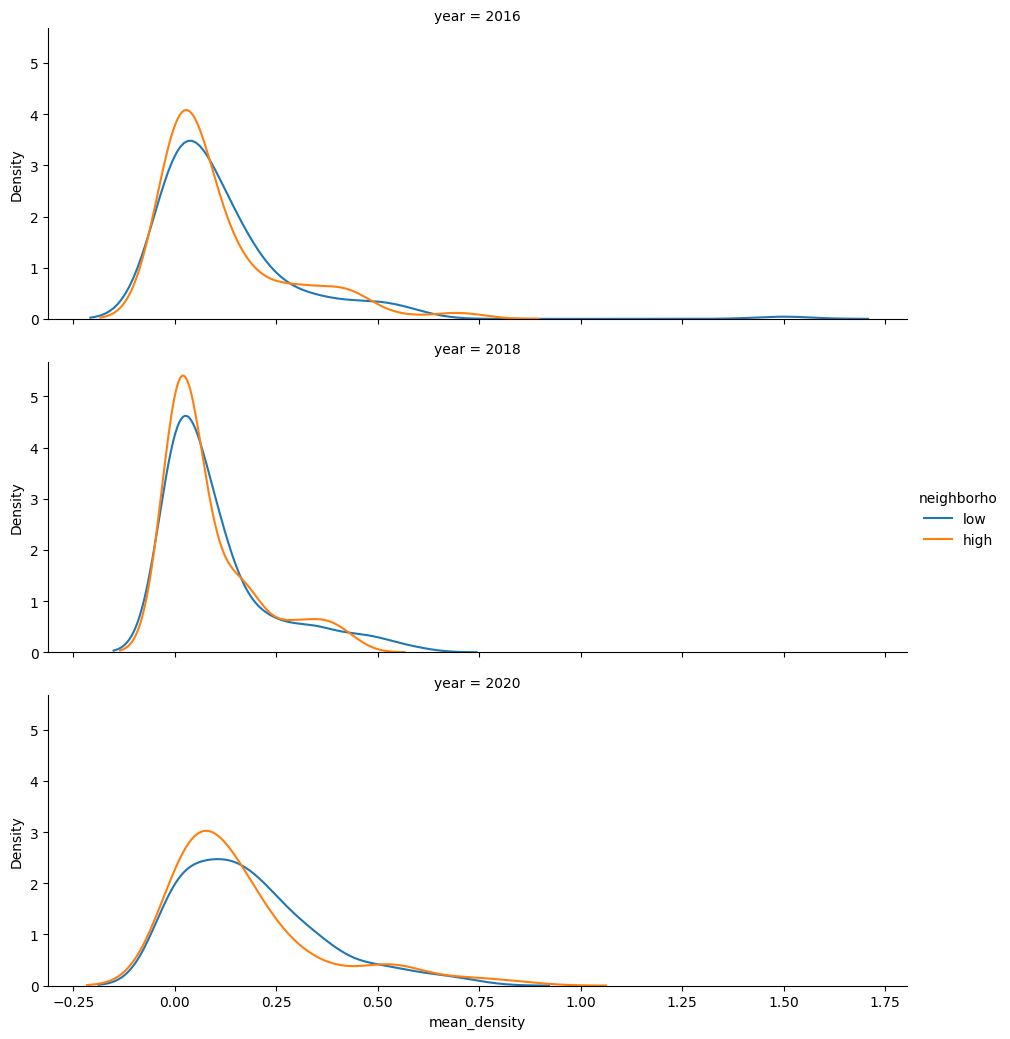

In [153]:
g = sns.FacetGrid(cbg_density, row="year", hue='neighborho', height=3.5, aspect=2.65)
g.map(sns.kdeplot, 'mean_density')
g.add_legend()
plt.show()

In [161]:
# Mean and SD estimates
aggregates = cbg_density.groupby(['year', 'neighborho']).agg(
    {'mean_density': ['mean', 'std', 'count']}).reset_index()
aggregates.columns = ['-'.join(l) for l in aggregates.columns]

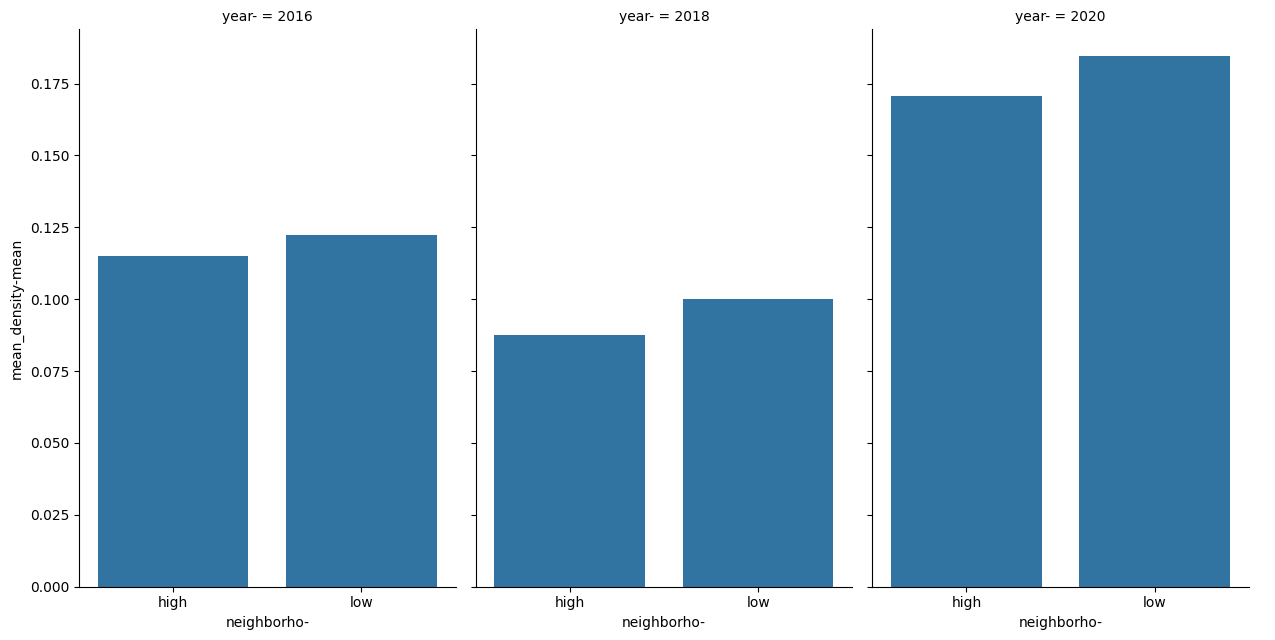

In [162]:
g = sns.FacetGrid(aggregates, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'mean_density-mean')
g.add_legend()
plt.show()

## 3. Power Analysis
Need to aggregate from the parcel level because we wish to compute the number of *parcels* that need to be reviewed.

In [ ]:
aggregates_from_parcel = parcel_density.groupby(['year', 'neighborho']).agg(
    {'parcel_density': ['mean', 'std', 'count']}).reset_index()
aggregates_from_parcel.columns = ['-'.join(l) for l in aggregates_from_parcel.columns]

In [182]:
aggregates_from_parcel

,year-,neighborho-,parcel_density-mean,parcel_density-std,parcel_density-count
0,2016,high,0.132210,0.359831,8010
1,2016,low,0.175018,0.426328,9799
2,2018,high,0.092884,0.306197,8010
3,2018,low,0.144913,0.389469,9799
4,2020,high,0.175655,0.437626,8010
5,2020,low,0.238698,0.492927,9799


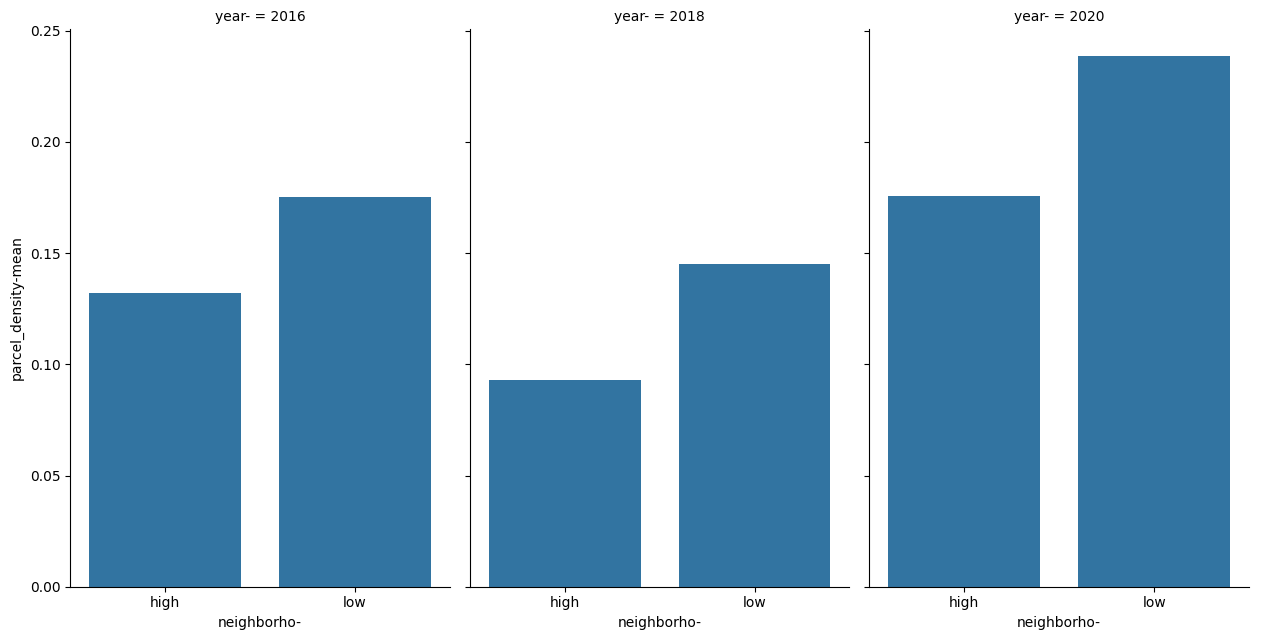

In [181]:
g = sns.FacetGrid(aggregates_from_parcel, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'parcel_density-mean')
g.add_legend()
plt.show()

## S_j

In [184]:
cbg_density.loc[cbg_density['year'] == '2020'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 498 to 746
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         249 non-null    object  
 1   mean_density  249 non-null    float64 
 2   std_density   241 non-null    float64 
 3   year          249 non-null    object  
 4   neighborho    245 non-null    object  
 5   geometry      249 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 13.6+ KB


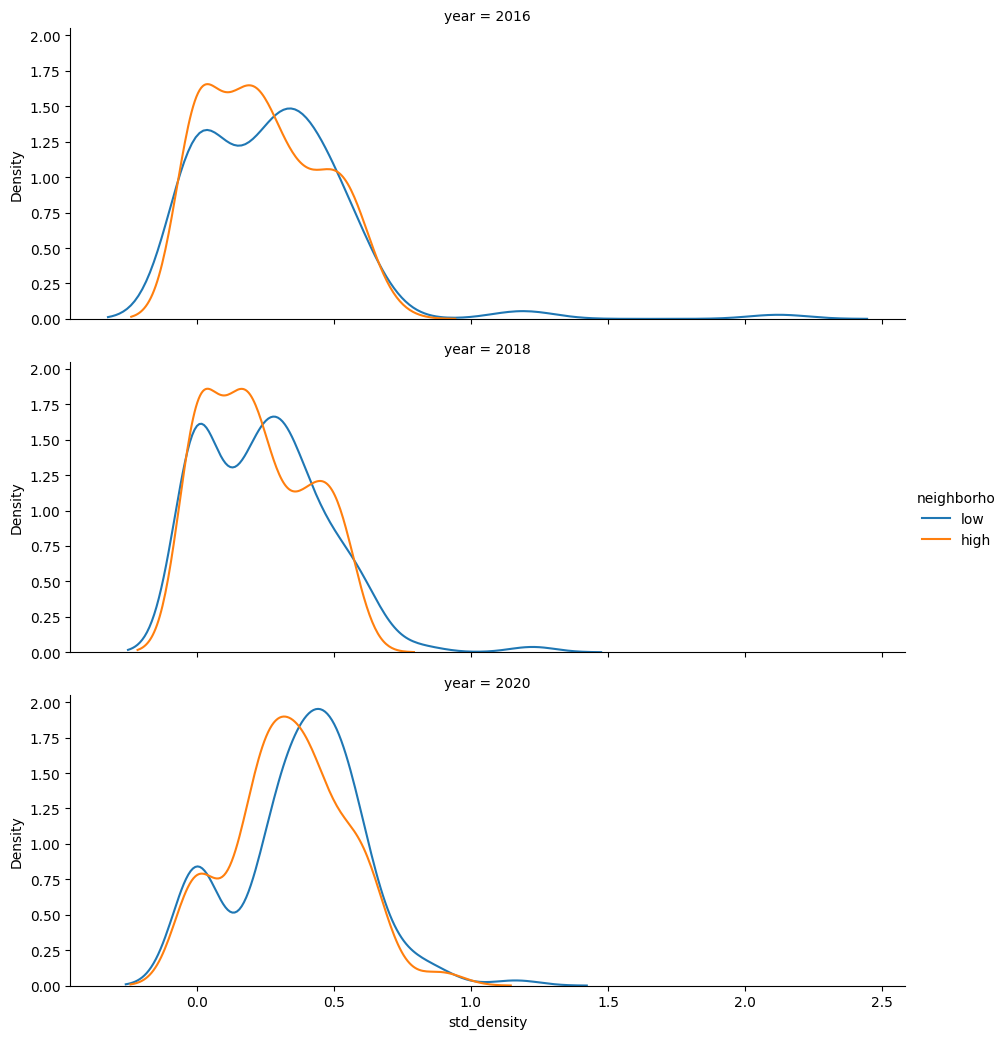

In [156]:
g = sns.FacetGrid(cbg_density, row="year", hue='neighborho', height=3.5, aspect=2.65)
g.map(sns.kdeplot, 'std_density')
g.add_legend()
plt.show()